In [1]:
### Load the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import minimize
from pysr import *
import pickle

plt.rc('text',usetex=True)
plt.rc('font',family='serif',size=14)

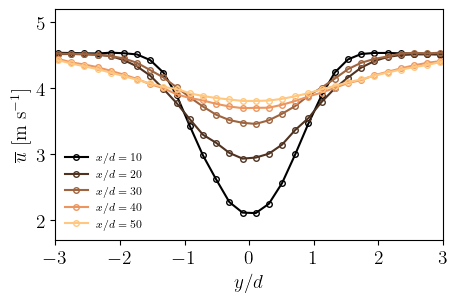

In [2]:
### Load experimental data from Cimbala, Nagib & Roshko, Journal of Fluid Mechanics, 190, 265-298, (1988).
### Replace with './Wake_params_flume.pkl' for the experiments conducted in the flume of the Department of Aeronautics, Imperial College London.

with open('./Wake_params.pkl', 'rb') as file:
    data = pickle.load(file)

x = data['x'] # streamwise locations, x/d
y = data['y'] # crosswise locations, y/d
u = data['u'] # mean streamwise velocity [m/s] 
U_inf = data['U_inf'] # freestream velocity [m/s]
nu = data['nu'] # viscosity [m^2/s]

nx = len(x)
ny = np.shape(y)[1]
ymid = int(ny/2)

# Plot profiles
color_map = cm.get_cmap('copper', len(x))
plt.figure(1,figsize=(5,3))
for i in range(len(x)):
    color = color_map(i / (len(x) - 1))
    plt.plot(y[i,:], u[i, :], '-o', label=f'$x/d={x[i]}$', markersize=4, mfc='none', color=color)
plt.xlabel(r'$y/d$')
plt.ylabel(r'$\overline{u}$ [m s$^{-1}$]')
plt.xlim([-3,3])
plt.ylim([1.7, 5.2])
plt.legend(frameon=False, fontsize=8)
plt.show()

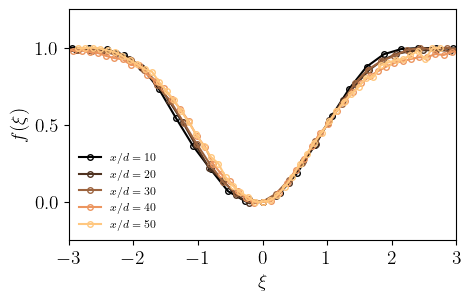

In [3]:
### Empirical scaling

# Define characteristic velocities
U_cntr  = u[:,ymid]
U_s     = U_inf - U_cntr
U_hw    = U_inf - 0.5*U_s

# Wake widths and scaled cross-stream variable xi
y12u = np.zeros((len(x)))
y12l = np.zeros((len(x)))
y12  = np.zeros((len(x)))
xi   = np.zeros((len(x),ny))
ywu  = np.zeros((len(x)))
ywl  = np.zeros((len(x)))
yw   = np.zeros((len(x)))
for i in range(len(x)):   
    y12u[i] = np.interp(U_hw[i], u[i,ymid:], y[i,ymid:])
    y12l[i] = np.interp(U_hw[i], np.flip(u[i,:ymid+1]), np.flip(y[i,:ymid+1]))
    y12[i]  = 0.5*(abs(y12u[i])+abs(y12l[i]))
    xi[i,:] = (y[i,:]-y[i,ymid])/(y12[i]-y[i,ymid])
    
    ywu[i] = np.interp(0.99*U_inf, u[i,ymid:], y[i,ymid:])
    ywl[i] = np.interp(0.99*U_inf, np.flip(u[i,:ymid+1]), np.flip(y[i,:ymid+1]))
    yw[i]  = 0.5*(abs(ywu[i])+abs(ywl[i]))
    
# Self-similar velocity profiles
fxi = np.zeros((len(x),ny))
for i in range(len(x)):
    fxi[i,:] = (u[i,:]-U_cntr[i])/U_s[i]
    
# Plot
plt.figure(1,figsize=(5,3))
for i in range(len(x)):
    color = color_map(i / (len(x) - 1))
    plt.plot(xi[i,:], fxi[i, :], '-o', label=f'$x/d={x[i]}$', markersize=4, mfc='none', color=color)

plt.xlabel(r'$\xi$')
plt.ylabel(r'$f(\xi)$')
plt.xlim([-3,3])
plt.ylim([-0.25, 1.25])
plt.legend(frameon=False, fontsize=8)
plt.show()

In [4]:
### Collapse the profiles

def loss(var, xin, yin):
    vari  = np.reshape(var,(len(x),3))
    xtran = vari[:,0][:,np.newaxis]*xin
    ytran = vari[:,1][:,np.newaxis]*yin + vari[:,2][:,np.newaxis]
    
    # interpolate at the transformed coordinates grid
    ninterp = nx
    llim    = np.max(np.amin(xtran,axis=1))
    ulim    = np.min(np.amax(xtran,axis=1))
    newgr   = np.linspace(llim,ulim,ninterp)
    new_y   = np.zeros((len(x),ninterp))
    for i in range(len(x)):
        new_y[i,:] = np.interp(newgr,xtran[i,:],ytran[i,:])
    
    # compute distances
    dist_mat = np.zeros((len(x),len(x)))
    for i in range(len(x)):
        for j in range(len(x)):
            dist_mat[i,j] = np.linalg.norm((new_y[i,:]-new_y[j,:])/np.sqrt(0.5*np.abs(new_y[i,:]+new_y[j,:])))**2
    
    dist = np.sum(dist_mat)/2.0
    
    return dist

# Define parameters and initialise transformation matrices
varopt = np.ones((len(x),3))
varopt[:,2] = 0
varopt = np.reshape(varopt,(3*len(x)))

bounds = np.zeros((3*len(x),2))
bounds[:,:] = None

# Optimisation
res = minimize(loss, varopt, args=(y, u), bounds=bounds)

varm = np.reshape(res.x,(len(x),3))
t1   = varm[:,0]
t2   = varm[:,1]
t3   = varm[:,2]

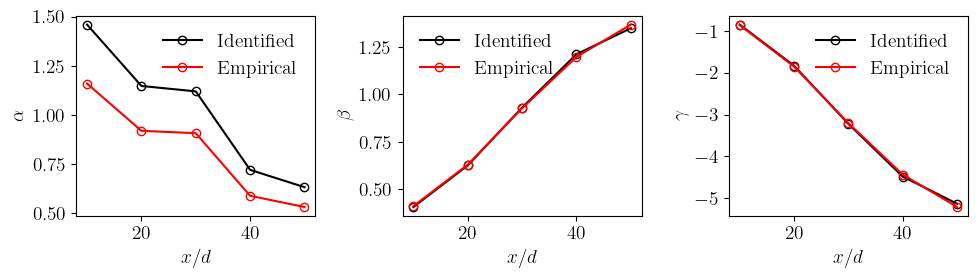

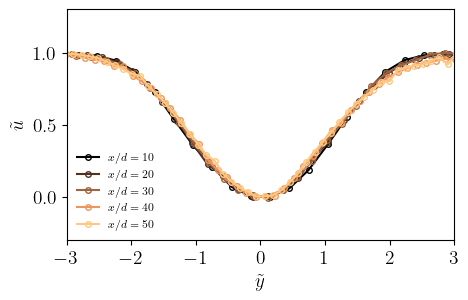

In [5]:
### Normalise and plot data

def normalise(field,transform):    
    fmin = np.average(np.min((field),axis=1))
    fmax = np.average(np.max((field),axis=1))
    f_norm = (field-fmin)/(fmax-fmin)
    t_norm = (transform-fmin)/(fmax-fmin)
    
    return f_norm, t_norm
    
xtran = np.zeros_like(y)
ytran = np.zeros_like(u)
for i in range(len(x)):
    xtran[i,:] = y[i,:]*t1[i]
    ytran[i,:] = u[i,:]*t2[i] + t3[i]
temp = np.average((np.min(ytran,axis=1)))
for i in range(len(x)):
    ytran[i,:] = ytran[i,:] - temp
    t3[i] = t3[i] - temp
ytran2, t2n = normalise(ytran,t2)
t3n = t3*(t2n/t2)

# Plot data
fig, ax = plt.subplots(1,3, figsize=(10,3))
ax[0].plot(x,t1,'-ko',mfc='none',label=r'Identified')
ax[0].plot(x,1/y12,'-ro',mfc='none',label=r'Empirical')
ax[0].set_xlabel(r'$x/d$')
ax[0].set_ylabel(r'$\alpha$')
ax[0].legend(frameon=False)

ax[1].plot(x,t2n,'-ko',mfc='none',label=r'Identified')
ax[1].plot(x,1/U_s,'-ro',mfc='none',label=r'Empirical')
ax[1].set_xlabel(r'$x/d$')
ax[1].set_ylabel(r'$\beta$')
ax[1].legend(frameon=False)

ax[2].plot(x,t3n,'-ko',mfc='none',label=r'Identified')
ax[2].plot(x,-U_cntr/U_s,'-ro',mfc='none',label=r'Empirical')
ax[2].set_xlabel(r'$x/d$')
ax[2].set_ylabel(r'$\gamma$')
ax[2].legend(frameon=False)
plt.tight_layout()

plt.figure(2,figsize=(5,3))
for i in range(len(x)):
    color = color_map(i / (len(x) - 1))
    plt.plot(xtran[i,:],ytran2[i,:], '-o', label=f'$x/d={x[i]}$', markersize=4, mfc='none', color=color)
plt.xlabel(r'$\tilde{y}$')
plt.ylabel(r'$\tilde{u}$')
plt.xlim([-3,3])
plt.ylim([-0.3, 1.3])
plt.legend(frameon=False, fontsize=8)

plt.show()

In [6]:
### Interpret transformations using PySR

# Interpret first identified transformation (alpha)
Xsr1   = np.array([x, yw, y12]).T
Ysr1   = 1/t1.copy()

model1 = PySRRegressor(
    model_selection='score',
    binary_operators=["+","-","*", "/"],
    unary_operators=[],
    complexity_of_constants=4,
    complexity_of_variables=1
    )
model1.fit(Xsr1, Ysr1)

# Interpret second identified transformation (beta)
Xsr2   = np.array([U_cntr, np.tile(U_inf,len(x)), x, np.tile(nu,len(x))]).T
X_dims = ["m/s", "m/s", "m", "m^2/s"]
Ysr2   = 1/t2n.copy()
Y_dims = ["m/s"]

model2 = PySRRegressor(
    model_selection='score',
    binary_operators=["+","-","*", "/"],
    unary_operators=[],
    dimensional_constraint_penalty=10**5,
    complexity_of_constants=4,
    complexity_of_variables=1
    )
model2.fit(Xsr2, Ysr2, X_units=X_dims, y_units=Y_dims)

# Interpret third identified transformation (gamma)
Xsr3   = np.array([U_cntr, np.tile(U_inf,len(x)), x, np.tile(nu,len(x))]).T
X_dims = ["m/s", "m/s", "m", "m^2/s"]
Ysr3   = t3n.copy()
Y_dims = [""]

model3 = PySRRegressor(
    model_selection='score',
    binary_operators=["+","-","*", "/"],
    unary_operators=[],
    dimensional_constraint_penalty=10**5,
    complexity_of_constants=4,
    complexity_of_variables=1
    )
model3.fit(Xsr3, Ysr3, X_units=X_dims, y_units=Y_dims)

/home/nikos/.local/lib/python3.10/site-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


/home/nikos/.local/lib/python3.10/site-packages/julia/juliainfo.py:93: UserWarning: julia warned:
The latest version of Julia in the `alpha` channel is 1.11.0-beta1+0.x64.linux.gnu. You currently have `1.10.0-beta2+0.x64.linux.gnu` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.0-beta1+0.x64.linux.gnu and update the `alpha` channel to that version.
  warnings.warn("{} warned:\n{}".format(julia, stderr))
/home/nikos/.local/lib/python3.10/site-packages/julia/juliainfo.py:93: UserWarning: julia warned:
The latest version of Julia in the `alpha` channel is 1.11.0-beta1+0.x64.linux.gnu. You currently have `1.10.0-beta2+0.x64.linux.gnu` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.0-beta1+0.x64.linux.gnu and update the `alpha` channel to that version.
  warnings.warn("{} warned:\n{}".format(julia, stderr))
/home/nikos/.local/lib/python3.10/site-packages/julia/juliainfo.py:93: UserWarning: julia warned:
The latest version of 

Started!

Expressions evaluated per second: 1.900e+05
Head worker occupation: 43.3%. This is high, and will prevent efficient resource usage. Increase `ncyclesperiteration` to reduce load on head worker.
Progress: 462 / 600 total iterations (77.000%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           6.246e-02  1.594e+01  y = x₂
5           2.512e-02  2.277e-01  y = (x₂ - (x₁ / x₀))
6           4.985e-04  3.920e+00  y = (x₂ * 0.82049)
8           4.985e-04  1.192e-07  y = (x₂ + (-0.17951 * x₂))
10          2.889e-04  2.727e-01  y = ((x₂ - (x₂ / x₀)) * 0.84844)
11          1.329e-04  7.769e-01  y = ((x₂ * 0.86699) + -0.067259)
12          1.700e-05  2.056e+00  y = (x₂ - (0.049567 * (x₁ + (x₁ / x₂))))
13          7.979e-06  7.567e-01  y = ((x₂ - (0.056072 * x₁)) - 0.08688)
15          7.979e-06  6.258e-07  y = ((x₂ - (0.028036 * (x₁ + x₁))) - 0.086879)
17          7.935e-0

/home/nikos/.local/lib/python3.10/site-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/nikos/.local/lib/python3.10/site-packages/julia/juliainfo.py:93: UserWarning: julia warned:
The latest version of Julia in the `alpha` channel is 1.11.0-beta1+0.x64.linux.gnu. You currently have `1.10.0-beta2+0.x64.linux.gnu` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.0-beta1+0.x64.linux.gnu and update the `alpha` channel to that version.
  warnings.warn("{} warned:\n{}".format(julia, stderr))


Started!

Expressions evaluated per second: 1.130e+05
Head worker occupation: 29.8%. This is high, and will prevent efficient resource usage. Increase `ncyclesperiteration` to reduce load on head worker.
Progress: 429 / 600 total iterations (71.500%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           5.068e+00  1.594e+01  y[m s⁻¹] = x₀[m s⁻¹]
3           2.417e-04  4.974e+00  y[m s⁻¹] = (x₁[m s⁻¹] - x₀[m s⁻¹])
8           1.946e-04  4.339e-02  y[m s⁻¹] = ((x₀[m s⁻¹] - x₁[m s⁻¹]) / -0.99841[⋅])
12          1.300e-04  1.008e-01  y[m s⁻¹] = (((x₁[m s⁻¹] - x₀[m s⁻¹]) - (x₀[m s⁻¹] - x₀[m s⁻¹])...
                                  ) * 1.0051[⋅])
13          1.158e-04  1.156e-01  y[m s⁻¹] = (((x₀[m s⁻¹] - x₁[m s⁻¹]) * -0.58972[⋅]) / 0.58525[...
                                  ⋅])
18          1.158e-04  1.478e-06  y[m s⁻¹] = (((x₀[m s⁻¹] - x₁[m s⁻¹]) * (-0.80858[⋅] - 0.12315[.

/home/nikos/.local/lib/python3.10/site-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/nikos/.local/lib/python3.10/site-packages/julia/juliainfo.py:93: UserWarning: julia warned:
The latest version of Julia in the `alpha` channel is 1.11.0-beta1+0.x64.linux.gnu. You currently have `1.10.0-beta2+0.x64.linux.gnu` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.0-beta1+0.x64.linux.gnu and update the `alpha` channel to that version.
  warnings.warn("{} warned:\n{}".format(julia, stderr))


Started!


PySRRegressor.equations_ = [
	   pick         score                                           equation   
	0        0.000000e+00                                                 x3  \
	1        4.325382e+00                                          (x0 / x1)   
	2        1.932039e+00                                         -3.1056297   
	3  >>>>  7.254054e+00                                   (x0 / (x0 - x1))   
	4        3.067314e-07                     ((x0 / x0) - (x1 / (x1 - x0)))   
	5        9.610549e-02                    (x0 / (x0 - (x1 / 0.99921966)))   
	6        4.943270e-04  ((x0 / (x0 - (x1 / 0.99921966))) - (-0.0154874...   
	
	            loss  complexity  
	0  100012.180000           1  
	1      17.501450           3  
	2       2.535130           4  
	3       0.001793           5  
	4       0.001793           9  
	5       0.001629          10  
	6       0.001621          20  
]

In [7]:
model1.sympy()

0.8204878*x2

In [8]:
model2.sympy()

-x0 + x1

In [9]:
model3.sympy()

x0/(x0 - x1)

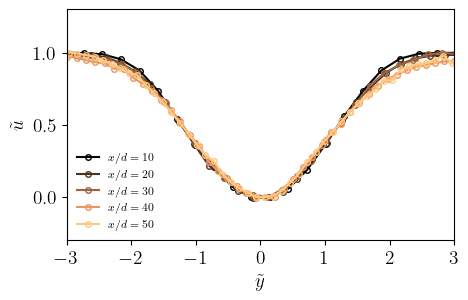

In [10]:
### Plot interpreted collapse

plt.figure(1,figsize=(5,3))
for i in range(len(x)):
    color = color_map(i / (len(x) - 1))
    plt.plot(y[i,:]/model1.predict(Xsr1)[i],u[i,:]/model2.predict(Xsr2)[i] + model3.predict(Xsr3)[i], '-o', label=f'$x/d={x[i]}$', markersize=4, mfc='none', color=color)
plt.xlabel(r'$\tilde{y}$')
plt.ylabel(r'$\tilde{u}$')
plt.xlim([-3,3])
plt.ylim([-0.3, 1.3])
plt.legend(frameon=False, fontsize=8)
plt.show()